In [1]:
import csv
import numpy as np
from queue import SimpleQueue

In [2]:
lst = []
with open('matchstat.csv', 'rt') as file:
    cr = csv.DictReader(file)
    for row in cr:
        lst.append(row)
lst_classified_in_matches = []
ok = {}
for row in lst:
    match_name = row['match_id']
    if match_name in ok:
        continue
    ok[match_name] = True
    lst_4_this_match = [row for row in lst if row['match_id'] == match_name]
    lst_classified_in_matches.append(lst_4_this_match)

In [3]:
# IMPORTANT: all calculations are based on the status INCLUDING the result of the current point

def calc_for_serve(match, player, f): # calculates the statistics for last three serves
    ret = []
    Q = SimpleQueue()
    Q_len = 0
    tot = 0
    for row in match:
        server = row['server']
        if server == player:
            flag = f(row, player)
            Q.put(flag)
            Q_len += 1
            tot += flag
            if Q_len > 3:
                tot -= Q.get()
                Q_len -= 1
        ret.append(0 if Q_len == 0 else tot / Q_len)
    return ret

def calc_for_strike(match, player, f): # calculating statistics for strikes
    ret = []
    Q = SimpleQueue()
    Q_len = 0
    tot = 0
    for row in match:
        flag = f(row, player)
        Q.put(flag)
        Q_len += 1
        tot += flag
        if Q_len > 3:
            tot -= Q.get()
            Q_len -= 1
        ret.append(tot / Q_len)
    return ret

def calc_net_rate(match, player):
    ret = []
    Q1 = SimpleQueue()
    Q2 = SimpleQueue()
    Q_len = 0
    tot = 0
    wins = 0
    for row in match:
        flag1 = 1 if row['p' + player + '_net_pt'] == '1' else 0
        flag2 = 1 if row['p' + player + '_net_pt_won'] == '1' else 0
        Q1.put(flag1)
        Q2.put(flag2)
        Q_len += 1
        tot += flag1
        wins += flag2
        if Q_len > 3:
            tot -= Q1.get()
            wins -= Q2.get()
            Q_len -= 1
        ret.append(0 if tot == 0 else wins / tot)
    return ret

def calc_for_this_strike(match, player, f): # statistics for this strike
    return [f(row, player) for row in match]

def calc_score_diff(match, player):
    ret = []
    Q = SimpleQueue()
    diff = 0
    cur_game = 0
    # Q_len = 0
    for row in match:
        game_no = int(row['game_no'])
        if cur_game != game_no:
            cur_game = game_no
            diff = 0
            while not Q.empty():
                Q.get()
            # Q_len = 0
        flag = (1 if row['point_victor'] == player else -1)
        Q.put(flag)
        # Q_len += 1
        diff += flag
        ret.append(diff / 3)
    return ret

def proc_match(match, player):

    # serve
    ace = calc_for_serve(match, player, lambda row, player: int(row['p' + player + '_ace']))
    double_fault = calc_for_serve(match, player, lambda row, player: -int(row['p' + player + '_double_fault']))
    first_serve = calc_for_serve(match, player, lambda row, _: (2 - int(row['serve_no'])))
    fast_win = calc_for_serve(match, player, lambda row, player: (1 if (int(row['rally_count']) <= 3 and row['point_victor'] == player) else 0))
    return_depth = calc_for_serve(match, ('1' if player == '2' else '2'), lambda row, _: (-1 if row['return_depth'] == 'NA' else (0 if row['return_depth'] == 'ND' else 1))) # 对手发球

    # strike
    winner = calc_for_strike(match, player, lambda row, player: int(row['p' + player + '_winner']))
    net_win_rate = calc_net_rate(match, player)

    # fatigue
    distance = calc_for_this_strike(match, player, lambda row, player: (-1 if float(row['p' + player  + '_distance_run']) > 45 else (0 if float(row['p' + player  + '_distance_run']) < 5 else (-float(row['p' + player  + '_distance_run']) - 5) / 40)))
    unforced_error = calc_for_strike(match, player, lambda row, player: -int(row['p' + player + '_unf_err']))
    # rally = calc_for_this_strike(match, player, lambda row, _: (-1 if int(row['rally_count']) > 10 else -(int(row['rally_count']) - 1) / 9))

    # mindset
    scored_last_point = calc_for_this_strike(match, player, lambda row, player: (1 if row['point_victor'] == player else 0))
    score_diff = calc_score_diff(match, player)

    opponent = ('2' if player == '1' else '1')
    ret = [{'server': (player if match[i]['server'] == player else opponent), 'ace': ace[i], 'double_fault': double_fault[i], 'first_serve': first_serve[i], 'fast_win': fast_win[i], 'return_depth': return_depth[i], 'winner': winner[i], 'net_win_rate': net_win_rate[i], 'distance': distance[i], 'unforced_error': unforced_error[i], 'scored_last_point': scored_last_point[i], 'score_diff': score_diff[i]} for i in range(len(match))]
    return ret

    # with open(output_file, 'w') as f:
    #     writer = csv.writer(f)

    #     writer.writerow(['ace', 'double_fault', 'first_serve', 'fast_win', 'return_depth', 'winner', 'net_win_rate', 'distance', 'unforced_error', 'rally', 'scored_last_point', 'score_diff'])
    #     for i in range(len(match)):
    #         writer.writerow([ace[i], double_fault[i], first_serve[i], fast_win[i], return_depth[i], winner[i], net_win_rate[i], distance[i], unforced_error[i], rally[i], scored_last_point[i], score_diff[i]])
        
    #     f.close()

def f(dic, player):
    server = dic['server']
    v = {}
    if server == player: # serve
        v = {'ace': 0.0198991509121888, 'net_win_rate': 0.0187773323271644, 'fast_win': 0.0771698779277567, 'first_serve': 0.0461077886989741, 'score_diff': 0.378306878306878, 'scored_last_point': 0.0756613756613757, 'winner': 0.0435435246185526, 'double_fault': 0.0198991509121888, 'unforced_error': 0.0801587301587302, 'distance': 0.240476190476191}
    else:
        v = {'net_win_rate': 0.0179308614091223, 'score_diff': 0.5, 'scored_last_point': 0.1, 'winner': 0.0606687997992346, 'return_depth': 0.121400338791643, 'unforced_error': 0.05, 'distance': 0.15}
    ret = sum([value * dic[key] for key, value in v.items()])
    return ret



# for cur_match in lst_classified_in_matches:
#     match_name = cur_match[0]['match_id']
#     proc_match(cur_match, '1', './data/' + match_name + '-player1.csv')
#     proc_match(cur_match, '2', './data/' + match_name + '-player2.csv')

In [7]:
for match in lst_classified_in_matches:
    match_name = match[0]['match_id']
    momentum1 = [f(row, '1') for row in proc_match(match, '1')]
    momentum2 = [f(row, '2') for row in proc_match(match, '2')]
    with open('data_proc/' + match_name + '.csv', 'w') as file:
        writer = csv.writer(file)
        writer.writerow(['point_no', 'p1_momentum', 'p2_momentum'])
        for i in range(len(momentum1)):
            writer.writerow([i + 1, momentum1[i], momentum2[i]])
        file.close()
    

TypeError: '_io.TextIOWrapper' object is not callable

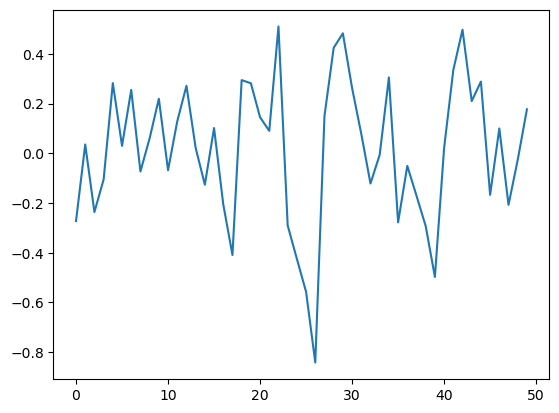

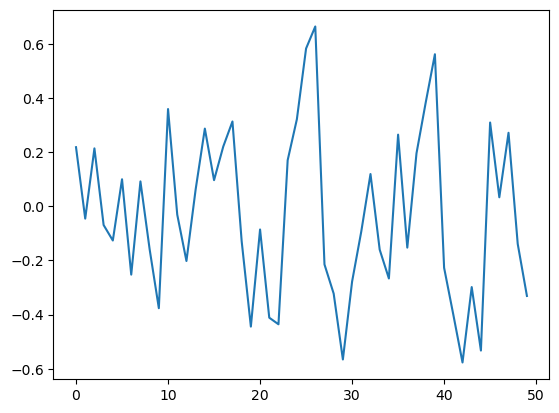

In [9]:

import matplotlib.pyplot as plt
# plt.plot(tot[0: 10])
# plt.show()
plt.plot(momentum1[: 50])
plt.show()
plt.plot(momentum2[: 50])
plt.show()

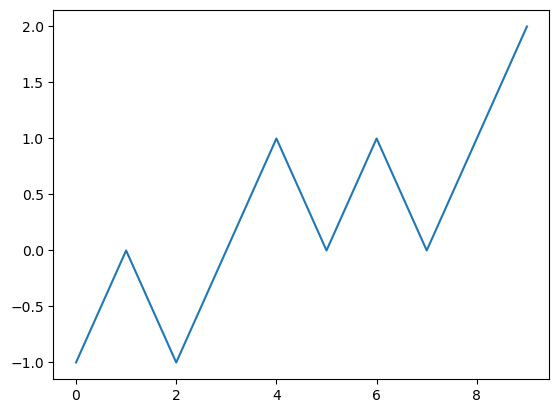

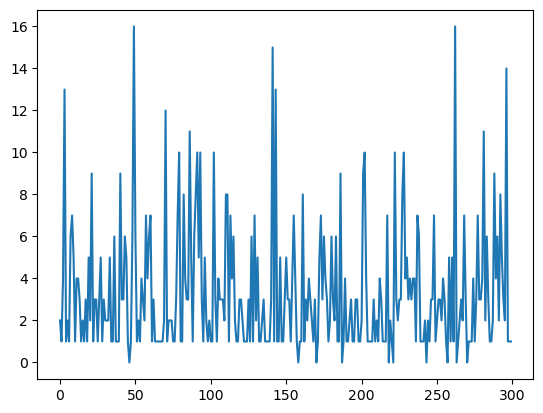